# Model Predictive Control of Hybrid Systems

In this notebook we extend the example presented in $\texttt{hybrid_mpc.ipynb}$ considering a more complex system: a cart-pole with two elastic walls.

## Demo

In [13]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controller_branch_and_bound import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stabilize a linearized cart-pole with: cart of mass $m_{\mathrm{c}}$, pole of mass $m_{\mathrm{p}}$, pole of length $l$, and subject to the gravity acceleration $g$; the pole is allowed to impact with two elastic walls with stiffness $k$ placed at distance $d$ from the origin

In [14]:
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
h = .05

We express the linearized dynamics in PieceWise Affine (PWA) form
\begin{align}
x(t+1) = A_i x(t) + B_i u(t) + c_i
\quad \text{if} \quad
(x(t),u(t)) \in \mathcal D_i
,
\quad i \in \{ 1, \ldots, s\}
\end{align}


In [15]:
# discretization method
method = 'explicit_euler'

# dynamics n.1 (in contact with left wall)
A1 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B1 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c1 = np.array([
    0.,
    0.,
    0.,
    (d*k)/(l*mp)
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (between the two walls)
A2 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [0., g*(mc+mp)/(l*mc), 0., 0.]
    ])
B2 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
S2 = LinearSystem.from_continuous(A2, B2, h, method)

# dynamics n.3 (in contact with right wall)
A3 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B3 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c3 = np.array([
    0.,
    0.,
    0.,
    -(d*k)/(l*mp)
    ])
S3 = AffineSystem.from_continuous(A3, B3, c3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

The domains of the PWA must be expressed as (bounded!) polyhedra

In [16]:
# state bounds
x_max = np.array([1.5*d, np.pi/6., 7., 5.])
x_min = -x_max

# state domain n.1 (in contact with left wall)
F1 = np.array([[1., -l, 0., 0.]])
g1 = np.array([-d])
X1 = Polyhedron.from_bounds(x_min, x_max)
X1.add_inequality(F1, g1)
assert X1.bounded

# state domain n.2 (between the two walls)
F2 = np.array([[-1., l, 0., 0.], [1., -l, 0., 0.]])
g2 = np.array([d, d])
X2 = Polyhedron.from_bounds(x_min, x_max)
X2.add_inequality(F2, g2)
assert X2.bounded

# state domain n.3 (in contact with right wall)
F3 = np.array([[-1., l, 0., 0.]])
g3 = np.array([-d])
X3 = Polyhedron.from_bounds(x_min, x_max)
X3.add_inequality(F3, g3)
assert X3.bounded

# list of state domains
X = [X1, X2, X3]

# input domain
u_max = np.array([20.])
u_min = - u_max

U = Polyhedron.from_bounds(u_min, u_max)

# domains
D1 = X1.cartesian_product(U)
D2 = X2.cartesian_product(U)
D3 = X3.cartesian_product(U)
D_list = [D1, D2, D3]

The overall PWA system can be defines as follows

In [17]:
S = PieceWiseAffineSystem(S_list, D_list)

Now we have all the ingredients to build the MPC controller

Q = np.eye(S.nx)*h
R = np.eye(S.nu)*h

P, K = S2.solve_dare(Q, R)
X_N = S2.mcais(K, D2, verbose=True)

In [18]:
# controller parameters
N = 50
Q = 10.*np.eye(S.nx)*h
R = .1*np.eye(S.nu)*h

# hybrid controller
controller = HybridModelPredictiveController(S, N, Q, R)

We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [19]:
x0 = np.array([0., 0., 2.5, 0.])

In [20]:
u, x, ms, cost = controller.feedforward_gurobi(x0)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 2800 rows, 1754 columns and 7850 nonzeros
Model has 250 quadratic objective terms
Variable types: 1604 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [5e-02, 2e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-03, 5e-01]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 891 rows and 699 columns
Presolve time: 0.03s
Presolved: 1909 rows, 1055 columns, 5838 nonzeros
Presolved model has 244 quadratic objective terms
Variable types: 921 continuous, 134 integer (134 binary)

Root relaxation: objective 8.952833e+00, 2826 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.95283    0  104          -    8.95283      -     -    0s
     0     0    9.24745    0  105          -    9.2474

We can use the plot functions to visualize the time evolution of the system

In [21]:
cost

59.87090223981489

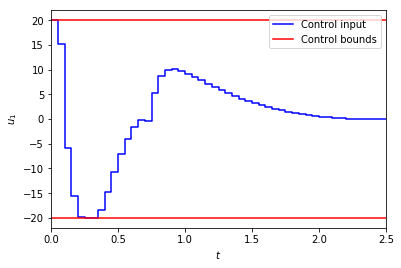

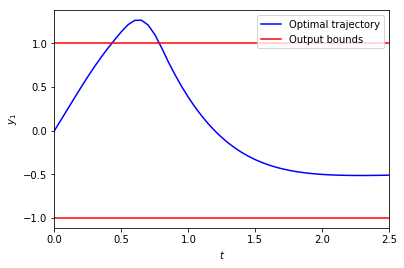

In [22]:
# input
plot_input_sequence(u, h, (u_min, u_max))
plt.show()

# output (horizontal position of the tip of the pole)
C = np.array([[1., -l, 0., 0.]])
y_min = np.array([-d])
y_max = np.array([d])
plot_output_trajectory(C, x, h, (y_min, y_max))
plt.show()

# Solution with my branch and bound code

In [23]:
from pympc.control.hybrid_benchmark.branch_and_bound_with_warm_start import branch_and_bound, best_first, breadth_first, depth_first

In [26]:
# solve with my branch and bound code
u, x, ms, cost, ws = controller.feedforward(x0, tree_file_name='bb_tree_example')
x1 = x[1]

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.023            1                4.507            inf             
  New incumbent    4.122            248              59.871           69.125          
  New incumbent    4.129            249              59.871           59.871          
  Solution found   4.137            250              59.871           59.871          

Explored 250 nodes in 4.137 seconds: optimal solution found with objective 59.871.


In [ ]:
# double check the bounds
for node in ws:
    cost_node = controller.solve_relaxation(x1, node.identifier)[1]
    if cost_node is not None:
        assert cost_node > node.lower_bound

In [ ]:
# solve from scratch
u, x, ms, cost, _ = controller.feedforward(x1, tree_file_name='t=1')

x2 = x[1]
controller.feedforward(x2, tree_file_name='t=2');

In [19]:
# with warm start
cost = controller.feedforward(x1, warm_start=ws, tree_file_name='t=0, ws')[3]

Warm start loaded with lower bound 57.308.
|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.018            1                57.375           inf             
  New incumbent    0.025            2                57.375           66.249          
  New incumbent    0.032            3                57.375           57.375          
  Solution found   0.039            4                57.375           57.375          

Explored 4 nodes in 0.040 seconds: optimal solution found with objective 57.375.


# Solve in closed loop

In [ ]:
N_sim = 100
u_sim = []
x_sim = [x0]
ws = None
for t in range(N_sim):
    print('Time step ' + str(t) + '.\r'),
    u, x, ms, cost, ws = controller.feedforward(
        x_sim[-1],
        warm_start=ws,
        printing_period=None,
        tree_file_name=None,
    )
    u_sim.append(u[0])
    x_sim.append(S.simulate(x_sim[-1],[u[0]])[0][1])

In [ ]:
plot_input_sequence(u_sim, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x_sim, h, (x_min, x_max))
plt.show()

# Simulation with disturbance

In [ ]:
np.random.seed(1)
w_max = 0.02

In [ ]:
x0 = np.array([0., 0., 0., 0.])
N_sim = 100
u_sim = []
x_sim = [x0]
w_sim = []
ws = None
for t in range(N_sim):
    print('Time step ' + str(t) + '.\r'),
    u, x, ms, cost, ws = controller.feedforward(
        x_sim[-1],
        warm_start=ws,
        printing_period=None,
        tree_file_name=None,
    )
    w_sim.append(w_max * np.random.randn(S.nx))
    u_sim.append(u[0])
    x_next = S.simulate(x_sim[-1],[u[0]])[0][1] + w_sim[-1]
    x_sim.append(x_next)

In [ ]:
plot_input_sequence(w_sim, h, (-w_max*np.ones(S.nx), w_max*np.ones(S.nx)))
plt.show()
plot_input_sequence(u_sim, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x_sim, h, (x_min, x_max))
plt.show()

## Animate results with MeshCat

Now we animate the closed-loop trajectory of the cart-pole with MeshCat (see https://github.com/rdeits/meshcat-python)

In [11]:
import time
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

Create a new visualizer

In [12]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Create the cart-pole

In [13]:
# cart-pole
cart_pole = vis["cart_pole"]

# cart
cart = cart_pole["cart"]
cart.set_object(g.Box([.3*l, .3*l, .3*l]), g.MeshLambertMaterial(color=0xff2222))

# pivot
pivot = cart["pivot"]
pivot.set_transform(tf.rotation_matrix(np.pi/2, [1, 0., 0.]))

# pole
pole = pivot["pole"]
pole.set_object(g.Box([.05*l, l, .05*l]), g.MeshLambertMaterial(color=0x2222ff))
pole.set_transform(tf.translation_matrix([0., .5, 0.]))

# left wall
left_wall = vis["left_wall"]
left_wall.set_object(g.Box([l, .05*l, l]), g.MeshLambertMaterial(color=0x22ff22))
left_wall.set_transform(tf.translation_matrix([0., -d, l]))

# right wall
right_wall = vis["right_wall"]
right_wall.set_object(g.Box([l, .05*l, l]), g.MeshLambertMaterial(color=0x22ff22))
right_wall.set_transform(tf.translation_matrix([0., d, l]))

Animate the results

In [14]:
# visualization function
def visualize_cart_pole(x):
    cart.set_transform(tf.translation_matrix([0, x[0], 0]))
    pivot.set_transform(tf.rotation_matrix(x[1] + np.pi/2, [1, 0, 0]))
vis.jupyter_cell()

In [16]:
# animation
for t in range(N):
    visualize_cart_pole(x[t])
    time.sleep(h)